**Prompt**: In this project, using supervised learning models, you will identify cell phone service customers who are more likely to stop using the service in the future and create a model that can predict if a certain customer will drop the service. Furthermore, it would be enlightening to analyze the top factors that influence user retention to help the company prevent user churn. The dataset contains information of customers' plans and usage of the service, as well as whether or not they stopped using the service eventually.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

matplotlib.rcParams['figure.autolayout'] = True
plt.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (10, 8)

churn_raw = pd.read_csv('data/churn.csv')

# Exploring the data

In [52]:
churn_raw.isnull().sum()

state                            0
account_length                   0
area_code                        0
phone_number                     0
intl_plan                        0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                1
number_customer_service_calls    0
churned                          0
dtype: int64

In [53]:
(churn_raw.total_eve_charge).str.count(r"\d+\.\d*").sum()

4995

Dealing with missing values: `total_intl_charge` has one null value, and `total_eve_charge` has 5 values of `"?"`.

In [54]:
churn = churn_raw.copy()
churn.total_eve_charge = churn_raw.total_eve_charge.replace({'?':np.nan})
churn = churn.dropna()
# Now handle datatypes:
churn = churn.assign(total_eve_charge=churn.total_eve_charge.astype('float64'), area_code=churn.area_code.astype('object'))

<AxesSubplot:>

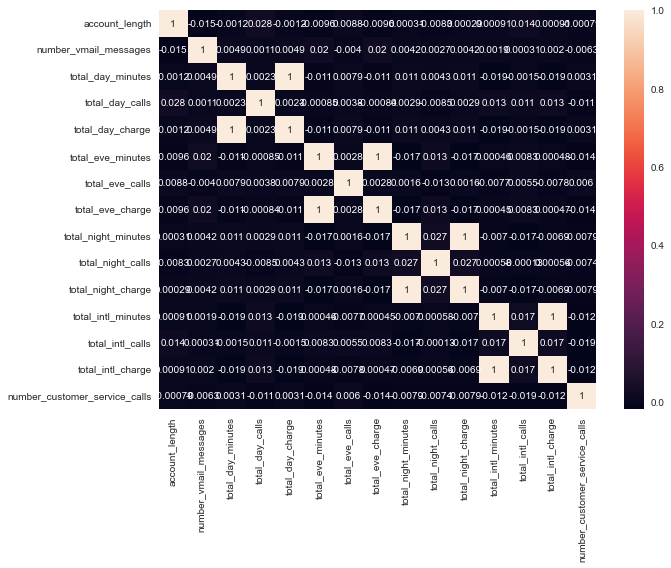

In [55]:
sns.heatmap(churn.corr(), annot=True)

Turns out `total_X_charge` correlates perfectly with `total_X_minutes` for `X`={`day`, `eve`, `night`, `intl`}. Therefore, these are redundant features.

In [56]:
df = churn.drop(churn.columns[churn.columns.str.match(r".+_charge")], axis=1)
df.nunique()

state                              51
account_length                    218
area_code                           3
phone_number                     4994
intl_plan                           2
voice_mail_plan                     2
number_vmail_messages              48
total_day_minutes                1960
total_day_calls                   123
total_eve_minutes                1879
total_eve_calls                   126
total_night_minutes              1851
total_night_calls                 131
total_intl_minutes                170
total_intl_calls                   21
number_customer_service_calls      10
churned                             2
dtype: int64

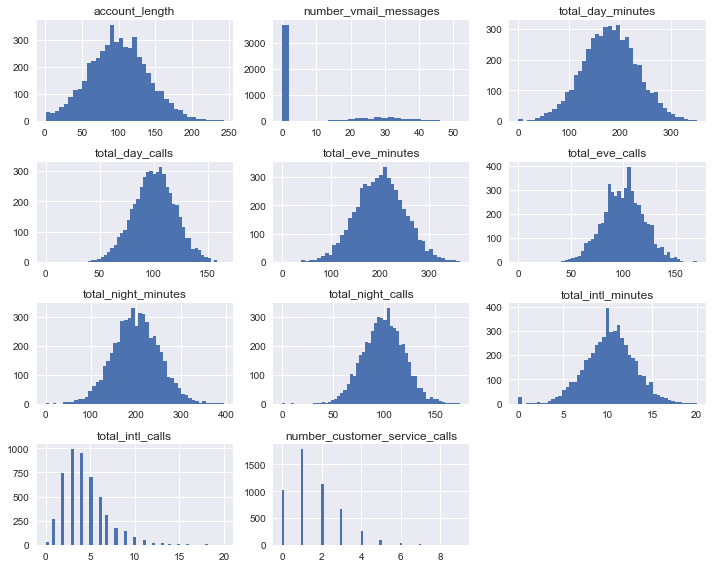

In [57]:
df.hist(bins='auto');

# Preprocessing

In [58]:
from sklearn.preprocessing import StandardScaler, RobustScaler

## Deciding how to scale features:

In [59]:
def scale_feats_test(df, features, named_transformers):
    namedtf = list(zip(*named_transformers))
    tf_names = list(namedtf[0])
    transformers = list(namedtf[1])
    
    print(f'Applying {tf_names} to features {features}')

    nrows = len(features)
    ncols = len(transformers)+1

    fig, axes = plt.subplots(nrows, ncols, sharey='row', figsize=(4*ncols, 3*nrows))
    for row in range(nrows):
        ft_name = features[row]
        data = df.loc[:,ft_name].to_numpy().reshape(-1,1)
        for col in range(ncols):
            if nrows==1: ax = axes[col]
            else: ax = axes[row, col]


            axtitle = ft_name
            if col==0: histdat = data
            else:
                axtitle += f' ({tf_names[col-1]})'
                histdat = transformers[col-1].fit_transform(data)

            ax.hist(histdat, bins='auto', color=f'C{col}')
            ax.set_title(axtitle)
    return None

Applying ['std scaler', 'robust scaler'] to features ['number_vmail_messages', 'total_intl_calls', 'number_customer_service_calls']


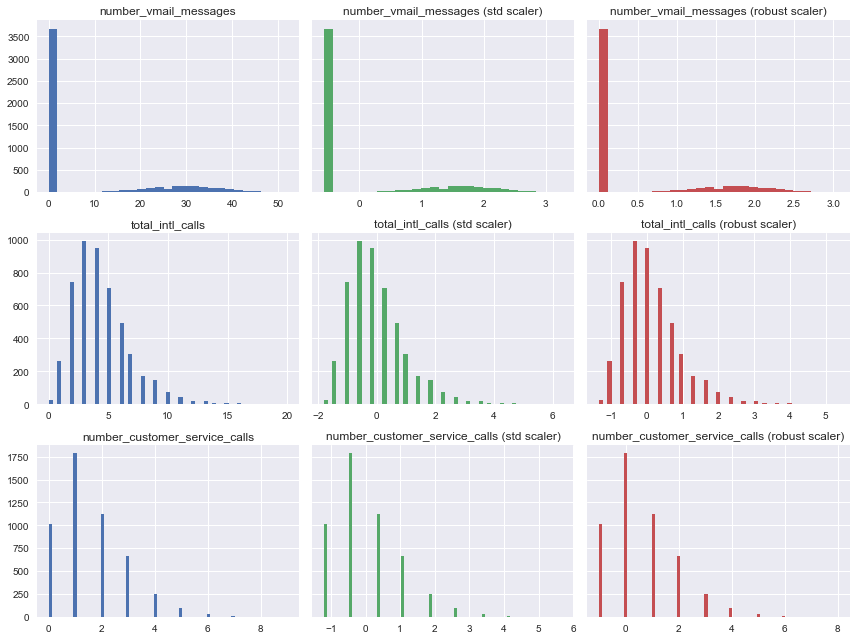

In [60]:
fts_test = ['number_vmail_messages', 'total_intl_calls', 'number_customer_service_calls']
tfs_test = [('std scaler', StandardScaler()), ('robust scaler', RobustScaler())]
scale_feats_test(df, fts_test, tfs_test)

In [61]:
print(f'{(df.number_vmail_messages==0).sum()} or {100*(df.number_vmail_messages==0).sum()/df.number_vmail_messages.size:.3f}% of customers have left no voicemail messages')

3675 or 73.588% of customers have left no voicemail messages


## Constructing a Preprocessor

In [62]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [63]:
y = df.churned.str.match(r".*True.*").astype(int) #converting churned column into binary: 
    # 0 -> no churn, 1 -> churn
cols_to_exclude = ['phone_number']
Xdf = df.drop(['churned']+cols_to_exclude, axis=1) #drop target variable and excluded columns

cat_feats = Xdf.columns[Xdf.dtypes=='object']
num_feats = Xdf.columns[Xdf.dtypes!='object']
print('categorical features: ', cat_feats.to_list())
print('numerical features: ', num_feats.to_list())

categorical features:  ['state', 'area_code', 'intl_plan', 'voice_mail_plan']
numerical features:  ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_eve_minutes', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_intl_minutes', 'total_intl_calls', 'number_customer_service_calls']


In [64]:
nonnorm_num_feats = ['number_vmail_messages', 
                     'total_intl_calls', 
                     'number_customer_service_calls']
norm_num_feats = [ft for ft in num_feats if ft not in nonnorm_num_feats]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='if_binary'), cat_feats),
    ('norm', StandardScaler(), norm_num_feats),
    ('nonnorm', RobustScaler(), nonnorm_num_feats)
])

# Choosing a model

## Choosing a metric

In [66]:
from sklearn.metrics import make_scorer, fbeta_score

In [67]:
fbscorer = make_scorer(fbeta_score, beta=2) # beta > 1 implies recall is more important

## Tuning estimators:

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [69]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdf, y, stratify=y)

### Logistic Regression

In [70]:
lr_pipe = Pipeline([
    ('prep', preprocessor),
    ('est', LogisticRegression(max_iter=1000))
])

lr_param_grid = {'est__class_weight': ['balanced', None],
                 'est__C': np.logspace(-3, 3, 7)}
lr_grid = GridSearchCV(lr_pipe,
                       param_grid=lr_param_grid,
                       scoring=fbscorer,
                       refit=True,
                       cv=15)
lr_grid.fit(Xtrain, ytrain)
lr = lr_grid.best_estimator_
lr

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['state', 'area_code', 'intl_plan', 'voice_mail_plan'], dtype='object')),
                                                 ('norm', StandardScaler(),
                                                  ['account_length',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_intl_minutes']),
                                                 ('nonnorm', RobustScaler(),
                                                  ['number_vmail_messages',
                                                   'total_intl_calls',
                                                   'number_customer_service_calls'])])),
                ('est',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])

It seems the optimal configuration is C=0.1 and balanced class weights

### Random Forest Classifier (onehot encoding)

In [79]:
rf_pipe0 = Pipeline([
    ('prep', preprocessor),
    ('est', RandomForestClassifier(n_jobs=6))
])

rf_param_grid0 = {
    'est__class_weight': ['balanced', 'balanced_subsample'],
    'est__max_depth': [5, 20, 50],
    'est__min_samples_leaf': np.arange(2, 12, 4),
    'est__n_estimators': [100, 150, 200]
}

rf_grid0 = GridSearchCV(rf_pipe0,
                       param_grid=rf_param_grid0,
                       scoring=fbscorer,
                       refit=True,
                       return_train_score=True,
                       cv=15)
rf_grid0.fit(Xtrain, ytrain)
rfc0 = rf_grid0.best_estimator_
rfc0

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['state', 'area_code', 'intl_plan', 'voice_mail_plan'], dtype='object')),
                                                 ('norm', StandardScaler(),
                                                  ['account_length',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_intl_minutes']),
                                                 ('nonnorm', RobustScaler(),
                                                  ['number_vmail_messages',
                                                   'total_intl_calls',
                                                   'number_customer_service_calls'])])),
                ('est',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=50, min_samples_leaf=10,
                                        n_estimators=150, n_jobs=6))])

In [82]:
res = pd.DataFrame(rf_grid0.cv_results_)
res.groupby('param_est__n_estimators').mean()[['mean_fit_time', 'mean_train_score', 'mean_test_score']]

,mean_fit_time,mean_train_score,mean_test_score
param_est__n_estimators,,,
100,0.158453,0.843597,0.743082
150,0.221681,0.844204,0.745720
200,0.284118,0.844893,0.745427


Note: `class_weight='balanced'` is similar to `'balanced_subsample'`, but the latter takes longer, so former is preferred. 

`'n_estimators'` seems to work similarly well for any value over 100, so using 100 since it is quicker to run.

In [85]:
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('est', RandomForestClassifier(n_jobs=6, class_weight='balanced'))
])

rf_param_grid = {
    'est__max_depth': [5, 10, 20, 40, 50],
    'est__min_samples_leaf': np.arange(2, 12, 2)
}

rf_grid = GridSearchCV(rf_pipe,
                       param_grid=rf_param_grid,
                       scoring=fbscorer,
                       refit=True,
                       return_train_score=True,
                       cv=15)
rf_grid.fit(Xtrain, ytrain)
rfc = rf_grid.best_estimator_
rfc

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['state', 'area_code', 'intl_plan', 'voice_mail_plan'], dtype='object')),
                                                 ('norm', StandardScaler(),
                                                  ['account_length',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_intl_minutes']),
                                                 ('nonnorm', RobustScaler(),
                                                  ['number_vmail_messages',
                                                   'total_intl_calls',
                                                   'number_customer_service_calls'])])),
                ('est',
                 RandomForestClassifier(class_weight='balanced', max_depth=40,
                                        min_samples_leaf=6, n_jobs=6))])

In [87]:
res = pd.DataFrame(rf_grid.cv_results_)
res.groupby('param_est__max_depth').mean()[['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
param_est__max_depth,,
5,0.764379,0.726036
10,0.830816,0.757484
20,0.872668,0.759593
40,0.877904,0.758689
50,0.877515,0.754729


In [88]:
res.groupby('param_est__min_samples_leaf').mean()[['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
param_est__min_samples_leaf,,
2,0.914997,0.725910
4,0.859267,0.755157
6,0.830145,0.764573
8,0.813244,0.756566
10,0.805628,0.754325


`'max_depth'` seems to contribute reletively little to test score -> setting to 15

`'min_samples_leaf'` optimal value is ~6

In [102]:
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('est', RandomForestClassifier(n_jobs=6, class_weight='balanced', max_depth=15, oob_score=False))
])

rf_param_grid = {
    'est__min_samples_leaf': np.arange(4, 12, 1)
}

rf_grid = GridSearchCV(rf_pipe,
                       param_grid=rf_param_grid,
                       scoring=fbscorer,
                       refit=True,
                       return_train_score=True,
                       cv=15)
rf_grid.fit(Xtrain, ytrain)
rfc = rf_grid.best_estimator_
rfc

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['state', 'area_code', 'intl_plan', 'voice_mail_plan'], dtype='object')),
                                                 ('norm', StandardScaler(),
                                                  ['account_length',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_intl_minutes']),
                                                 ('nonnorm', RobustScaler(),
                                                  ['number_vmail_messages',
                                                   'total_intl_calls',
                                                   'number_customer_service_calls'])])),
                ('est',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_leaf=5, n_jobs=6))])

## Comparing Models

              precision    recall  f1-score   support

    No Churn       0.95      0.77      0.85      1072
       Churn       0.35      0.76      0.48       177

    accuracy                           0.77      1249
   macro avg       0.65      0.76      0.67      1249
weighted avg       0.87      0.77      0.80      1249



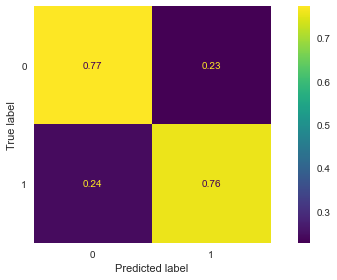

In [112]:
print(classification_report(ytest, lr.predict(Xtest), target_names=['No Churn', 'Churn']))
fig, ax = plt.subplots(1,1, figsize =(8,4))
ax.grid(False)
ConfusionMatrixDisplay.from_estimator(lr, Xtest, ytest, ax=ax,normalize='true')

              precision    recall  f1-score   support

    No Churn       0.97      0.95      0.96      1072
       Churn       0.73      0.81      0.77       177

    accuracy                           0.93      1249
   macro avg       0.85      0.88      0.86      1249
weighted avg       0.93      0.93      0.93      1249



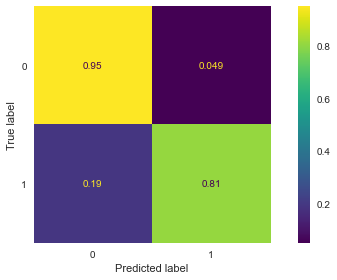

In [110]:
print(classification_report(ytest, rfc.predict(Xtest), target_names=['No Churn', 'Churn']))
fig, ax = plt.subplots(1,1, figsize =(8,4))
ax.grid(False)
ConfusionMatrixDisplay.from_estimator(rfc, Xtest, ytest, ax=ax,normalize='true')

The Random Forest classifier performs well and is definitively superior to logistic regression.

# Evaluating feature importances

In [139]:
transformed_cols = [c.split('__')[1] for c in rfc.named_steps['prep'].get_feature_names_out()]
feat_importances = pd.Series(rfc.named_steps['est'].feature_importances_, index=transformed_cols).sort_values(ascending=False)
feat_importances

total_day_minutes                0.257684
number_customer_service_calls    0.168115
intl_plan_ yes                   0.097699
total_eve_minutes                0.070231
total_intl_minutes               0.054541
                                   ...   
state_AL                         0.000298
state_AK                         0.000298
state_NC                         0.000211
state_FL                         0.000207
state_IA                         0.000150
Length: 67, dtype: float64

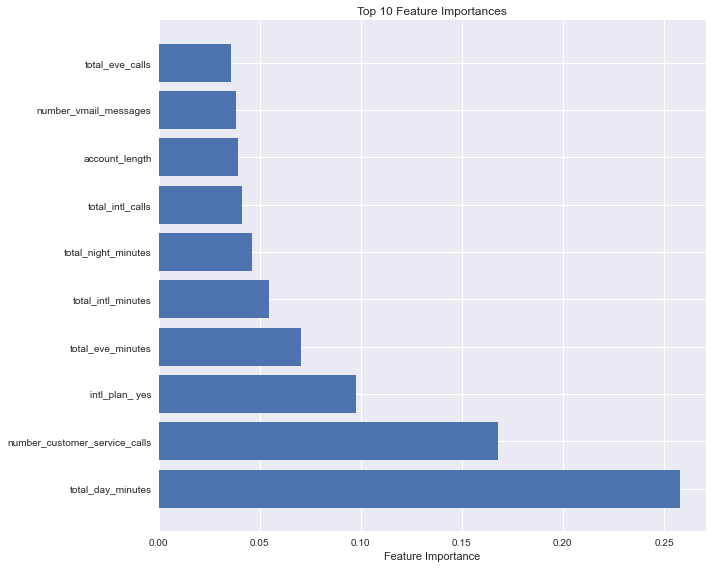

In [152]:
plt.barh(range(10), feat_importances.values[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature Importance")
plt.yticks(range(10), feat_importances.index[:10]);

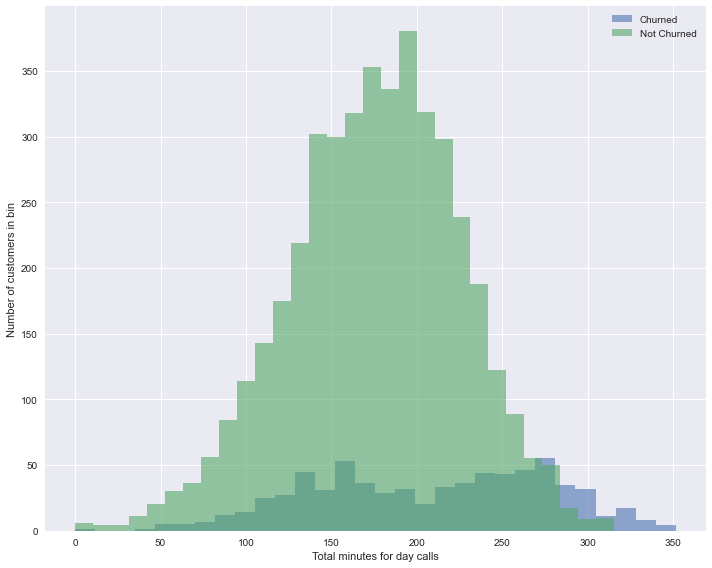

In [162]:
Xdf.total_day_minutes[y==1].hist(alpha=.6, bins=30, label="Churned")
Xdf.total_day_minutes[y==0].hist(alpha=.6, bins=30, label="Not Churned", ax=plt.gca())
plt.xlabel("Total minutes for day calls")
plt.ylabel("Number of customers in bin")
plt.legend()


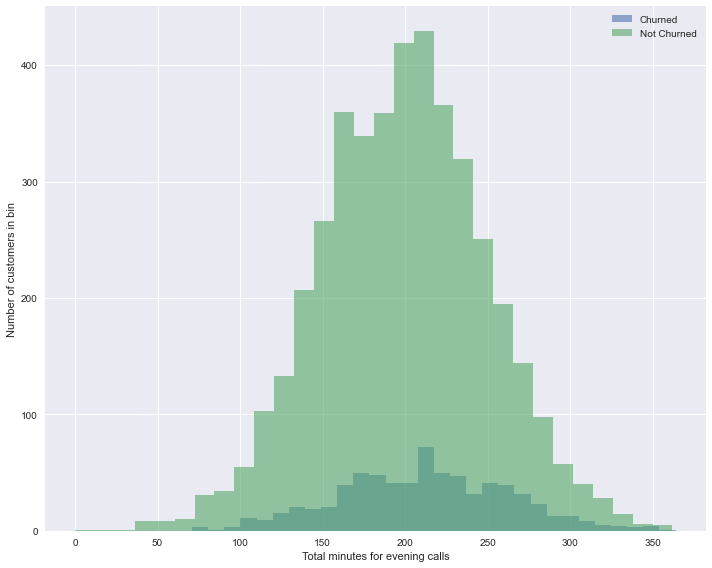

In [165]:
Xdf.total_eve_minutes[y==1].hist(alpha=.6, bins=30, label="Churned")
Xdf.total_eve_minutes[y==0].hist(alpha=.6, bins=30, label="Not Churned", ax=plt.gca())
plt.xlabel("Total minutes for evening calls")
plt.ylabel("Number of customers in bin")
plt.legend()


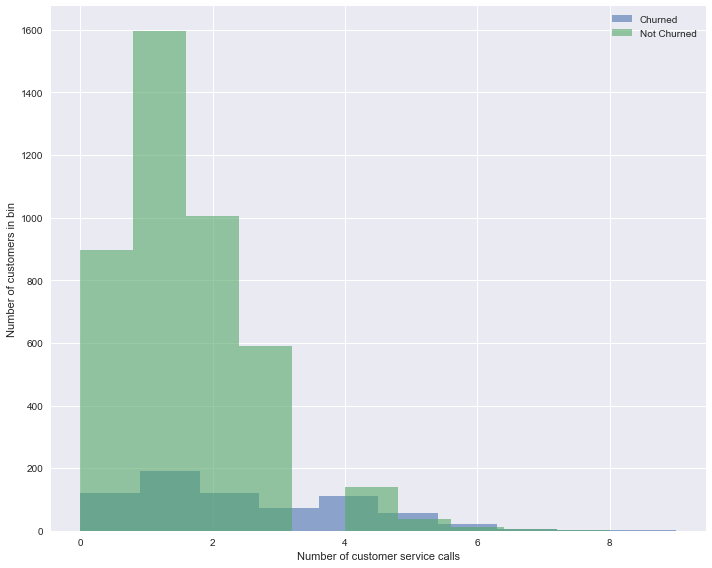

In [164]:
Xdf.number_customer_service_calls[y==1].hist(alpha=.6, bins=10, label="Churned")
Xdf.number_customer_service_calls[y==0].hist(alpha=.6, bins=10, label="Not Churned", ax=plt.gca())
plt.xlabel("Number of customer service calls")
plt.ylabel("Number of customers in bin")
plt.legend()


# Conclusion

A good model to predict the likelihood a particular customer will leave the service (i.e. churn) is one using a random forest classifier, as found above.

The two features/aspects which are most important in determining if a given customer will leave the service are `total_day_minutes`, the total minutes that the customer spends on day calls, as well as `number_customer_service_calls`, the number of customer service calls by the customer. If the former exceeds 250 minutes, or if the latter exceeds 3 calls, then that customer is particularly likely to leave the service.